In [8]:
import pandas as pd
import numpy as np

df = pd.read_excel('../data/meta_ads_cleaned.xlsx', engine='openpyxl')

df.head()

traffic_df = df[df['Result indicator'] == 'actions:link_click'].copy()
traffic_df.reset_index(drop=True, inplace=True)
traffic_df.head()


,Campaign name,Campaign Delivery,Platforme,Device,Placement,Objective,Result indicator,Ad set budget,Ad set budget type,Amount spent,...,Cost per app install (USD),Adds to cart,Adds to cart conversion value,Cost per add to cart (USD),Checkouts Initiated,Checkouts initiated conversion value,Cost per checkout initiated (USD),Landing page views,Cost per landing page view (USD),Cost per purchase (USD)
0,SO/2024/0884 - Orange - Lancement posts digita...,not_delivering,Instagram,Desktop,Feed,Traffic,actions:link_click,4505.81,Using ad set budget,4505.81,...,2.114411,243,71647.6,18.542428,3468,1788.29,1.299253,5850,0.770224,1501.936667
1,SO/2025/0206 Orange - Lancement posts digitaux...,active,Audience Network,Desktop,"Native, banner & interstitial",Traffic,actions:link_click,475.32,Using ad set budget,475.32,...,2.353069,111,249.0,4.282162,802,0.00,0.592668,13547,0.035087,475.320000
2,SO/2024/0582 - Orange - Campagne achat et rech...,not_delivering,Audience Network,In-app,"Native, banner & interstitial",Traffic,actions:link_click,577.18,Using ad set budget,577.18,...,0.000000,14,0.0,41.227143,427,0.00,1.351710,2759,0.209199,577.180000
3,SO/2023/0333 - Orange - Campagne caravane Bal...,not_delivering,Facebook,In-app,Facebook Reels,Traffic,actions:link_click,368.26,Using ad set budget,368.26,...,0.000000,3,755.1,122.753333,23,0.00,16.011304,2,184.130000,0.000000
4,SO/2024/0576 - Orange - Lancement posts digita...,not_delivering,Audience Network,In-app,"Native, banner & interstitial",Traffic,actions:link_click,3006.70,Using ad set budget,3006.70,...,0.873279,1023,59950.0,2.939101,8444,277.50,0.356075,160516,0.018731,150.335000


In [9]:
categorical_cols = ['Platforme', 'Placement', 'Device', 'Ad set budget type']

# Applying one-hot encoding
traffic_df_encoded = pd.get_dummies(traffic_df, columns=categorical_cols, drop_first=True)


In [10]:
traffic_df_encoded['Starts'] = pd.to_datetime(traffic_df_encoded['Starts'])

traffic_df_encoded['day'] = traffic_df_encoded['Starts'].dt.day
traffic_df_encoded['month'] = traffic_df_encoded['Starts'].dt.month
traffic_df_encoded['weekday'] = traffic_df_encoded['Starts'].dt.weekday


In [11]:
# Reapply log1p transformations for all relevant KPIs
traffic_df_encoded['log_CTR'] = np.log1p(traffic_df_encoded['CTR (all)'])
traffic_df_encoded['log_CPC'] = np.log1p(traffic_df_encoded['CPC (all) (USD)'])
traffic_df_encoded['log_spend'] = np.log1p(traffic_df_encoded['Amount spent'])
traffic_df_encoded['log_clicks'] = np.log1p(traffic_df_encoded['Clicks (all)'])
traffic_df_encoded['log_reach'] = np.log1p(traffic_df_encoded['Reach'])
traffic_df_encoded['log_impressions'] = np.log1p(traffic_df_encoded['Impressions'])

In [12]:
features_to_keep = [
    'log_CTR',                    # Target
    'log_CPC', 'log_spend',       # Use spend, drop reach or impressions
    'log_clicks', 
    'day', 'month', 'weekday'     # Time-based
]

# Add one-hot encoded categorical columns dynamically
features_to_keep += [col for col in traffic_df_encoded.columns if any(p in col for p in ['Platforme_', 'Placement_', 'Device_', 'Ad set budget type_'])]

# Build final DataFrame
traffic_model_df = traffic_df_encoded[features_to_keep].dropna()

# Separate features and target
X_traffic = traffic_model_df.drop('log_CTR', axis=1)
y_traffic = traffic_model_df['log_CTR']


In [13]:
print("Feature set shape:", X_traffic.shape)
print("Target variable shape:", y_traffic.shape)
X_traffic.head()


Feature set shape: (108, 16)
Target variable shape: (108,)


,log_CPC,log_spend,log_clicks,day,month,weekday,Platforme_Facebook,Platforme_Instagram,Placement_Facebook Reels,Placement_Facebook Stories,Placement_Facebook profile feed,Placement_Feed,Placement_Instagram Stories,"Placement_Native, banner & interstitial",Device_In-app,Ad set budget type_Using ad set budget
0,0.060914,8.413345,11.180804,16,1,3,False,True,False,False,False,True,False,False,False,True
1,0.005833,6.166090,11.305397,18,3,1,False,False,False,False,False,False,False,True,False,True
2,0.020366,6.359885,10.241887,15,8,3,False,False,False,False,False,False,False,True,True,True
3,0.008989,5.911501,10.616045,27,12,2,True,False,True,False,False,False,False,False,True,True
4,0.005386,8.008931,13.229742,22,8,3,False,False,False,False,False,False,False,True,True,True


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_traffic, y_traffic, test_size=0.2, random_state=42
)


In [15]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)


LinearRegression()

In [16]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred = lr_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


RMSE: 0.3923
R² Score: 0.4433


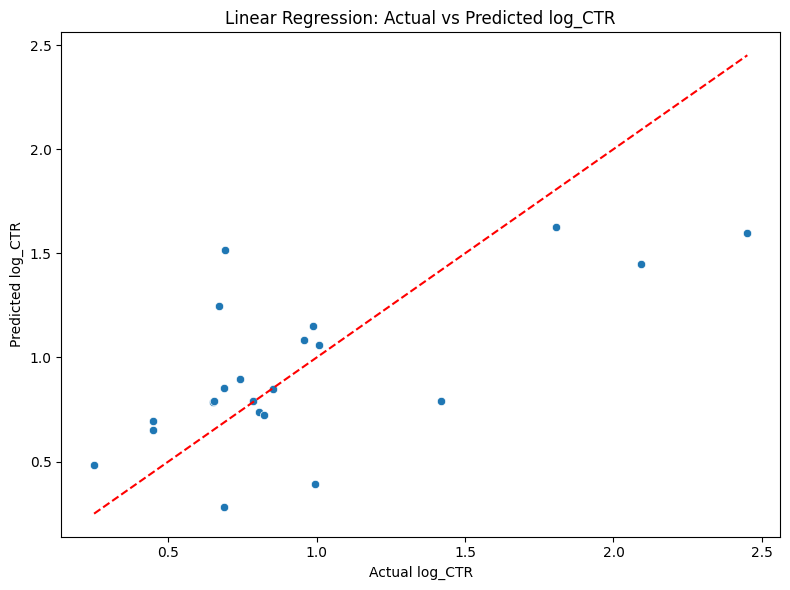

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual log_CTR")
plt.ylabel("Predicted log_CTR")
plt.title("Linear Regression: Actual vs Predicted log_CTR")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.tight_layout()
plt.show()


##  Baseline Linear Regression – log_CTR Prediction (Traffic Campaigns)

A baseline linear model was trained using log-transformed and one-hot encoded features. The model aims to predict `log_CTR`.

###  Evaluation Results:
- **Root Mean Squared Error (RMSE)**: `0.3923`
- **R² Score**: `0.4433`

 This means that the model explains approximately 44% of the variance in `log_CTR`. While this is a good starting point, CTR prediction is inherently noisy and further gains are likely through non-linear models or regularization (Ridge, Random Forest, XGBoost).


In [19]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define alpha range
alphas = np.logspace(-3, 3, 100)

# Cross-validated Ridge
ridge_model = RidgeCV(alphas=alphas, scoring='neg_root_mean_squared_error', cv=5)
ridge_model.fit(X_train, y_train)

# Predict and evaluate
ridge_preds = ridge_model.predict(X_test)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_preds))
ridge_r2 = r2_score(y_test, ridge_preds)

print(f"Best alpha: {ridge_model.alpha_}")
print(f"Ridge RMSE: {ridge_rmse:.4f}")
print(f"Ridge R²: {ridge_r2:.4f}")


Best alpha: 3.7649358067924674
Ridge RMSE: 0.3950
Ridge R²: 0.4355


In [20]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_preds = rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_r2 = r2_score(y_test, rf_preds)

print(f"Random Forest RMSE: {rf_rmse:.4f}")
print(f"Random Forest R²: {rf_r2:.4f}")


Random Forest RMSE: 0.2688
Random Forest R²: 0.7386


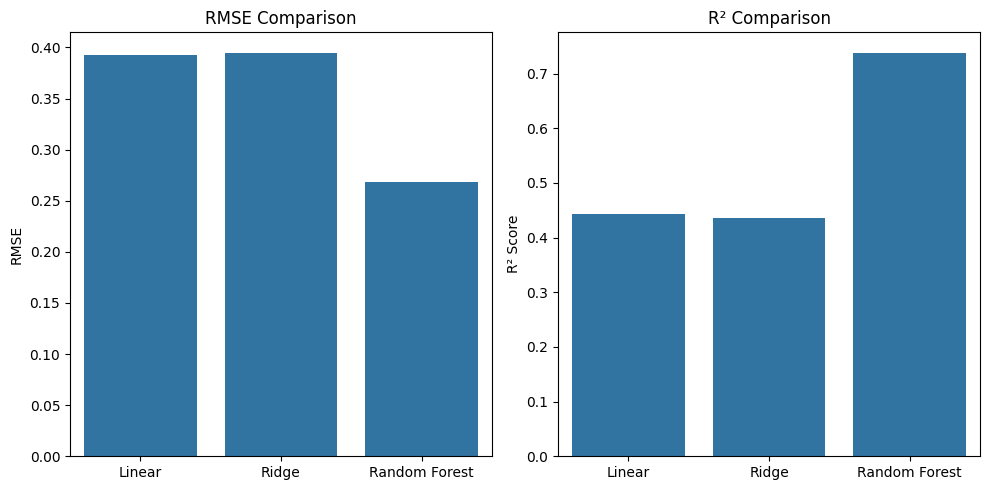

In [21]:
import matplotlib.pyplot as plt

models = ['Linear', 'Ridge', 'Random Forest']
rmse_vals = [rmse, ridge_rmse, rf_rmse]
r2_vals = [r2, ridge_r2, rf_r2]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=models, y=rmse_vals)
plt.title("RMSE Comparison")
plt.ylabel("RMSE")

plt.subplot(1, 2, 2)
sns.barplot(x=models, y=r2_vals)
plt.title("R² Comparison")
plt.ylabel("R² Score")

plt.tight_layout()
plt.show()
